# Working with ISIC Images
Images are at the heart of the ISIC Archive, and this notebook
will give you a sense of what the ```isicarchive``` package
can do in terms of retrieving images from the archive, and the
kinds of methods you can apply to them.
## Preparation
We'll start again by creating an ```IsicApi``` object, which
allows us to access the various pieces of information and images
stored in the archive. The call to ```cache_images()``` will
then download information (and meta information) about all
images that are available--if you are logged in as a regular
user, you may have access to additional images! **If you're
using the ```cache_images()``` method, please use a different
cache folder if you want to work with both publicly available
and private images in separate sessions.**

Next, we'll select all images from the ```IsicApi``` object that
have a specific diagnosis, and then display those images.

In [1]:
# imports
import os
from isicarchive.api import IsicApi

# Settings (please adapt to your needs!)
username = 'weberj3@mskcc.org'

# DO NOT PUT A PASSWORD into the document, it will be requested,
# or you can store it in a privately readable ~/.netrc file!

doc_folder = 'Z:\\10.Imaging Informatics\\'
# doc_folder = '/Data/MSKCC/'
cache_folder = doc_folder + 'ISIC' + os.sep + 'cache'

# setting debug flag, this will print out every web-API operation
debug = True

# Preparation
api = IsicApi(username, cache_folder=cache_folder, debug=debug)

In [ ]:
# caching images and segmentations; this can take a long time!!
# so you may want to skip this cell for now...
api.cache_images()
api.cache_segmentations()

In [ ]:
# list available studies (depends on user authentication!)
api.studies

In [ ]:
# show the number of images in each study
for (study_name, study_id) in api.studies.items():
    print('Study "' + study_name + '" has ' + str(len(api._studies[study_id]['images'])) + ' images.')

In [5]:
# load a study,
# add the meta-data file (exemplar feature in CSV) as exemplar meta_data,
# and cache the images associated with it
study_folder = doc_folder + 'EASY' + os.sep + 'PILOT' + os.sep
if not os.path.exists(study_folder):
    os.mkdir(study_folder)
study = api.study('ISIC Annotation Study - All Features', exemplar=study_folder + 'pilot.csv')
study.cache_image_data()

Requesting (auth) https://isic-archive.com/api/v1/annotation with params: {'studyId': '5a32cde91165975cf58a469c', 'detail': 'true'}
Retrieved list with 840 items.


In [ ]:
# alternatively, manually load additional meta data later
study.load_meta_data(study_folder + 'study1.csv', dict_key='ISIC_ID',
    list_to_dict=True, meta_key='exemplar', extract_key='feature')

In [ ]:
# load the annotation data
study.load_annotations()

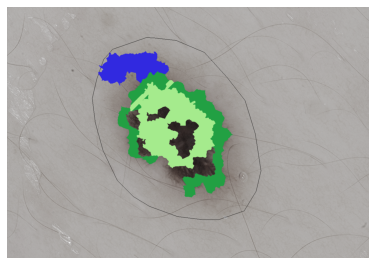

In [7]:
# create heatmap with default settings
(heatmap, stats) = study.image_heatmap('ISIC_0016094',
    mix_colors=False,underlay_gray=0.8,users=['578e64b09fc3c10d6fd12e4f'])
api.display_image(heatmap)

In [ ]:
# display stats on the annotation features
stats['featcols']

In [ ]:
# load a dataset
dataset = api.dataset('HAM10000')
dataset

In [ ]:
# load image information into the dataset
dataset.load_images()

In [ ]:
# select images from a dataset
selection = api.select_images(['dataset.name', '==', 'Lymphoma_250_bt'])

# and create a meta-dictionary as a CSV
md = api.write_csv(doc_folder + 'Lymphoma_250_bt_metadata.csv', api.selected_metadata())

In [ ]:
# load image and display image data
image = api.image(study.images[0])
image.load_image_data()
image.show_in_notebook()

In [ ]:
# create meta information of one image
mi = image.meta_info()
import json
mi_json = json.dumps(mi)
with open(doc_folder + image.name + '_info.json', 'w') as json_file:
    json_file.write(mi_json)

In [ ]:
# load image's superpixel information and map array
image.load_superpixels()
image.map_superpixels()

In [ ]:
# create superpixel outlines as SVG paths
superpixel_colors = api.superpixel_colors()
outline_svg = image.superpixel_outlines(
    out_format='osvg', path_attribs=superpixel_colors)
outlines = image.superpixel_outlines(
    out_format='osvgp', path_attribs=superpixel_colors)

# display one path
outlines[0]

In [ ]:
# retrieve segmentation (supports image name, image ID (via additional request), and segmentation ID)
segmentation = api.segmentation('ISIC_0000000')

In [ ]:
# get superpixels in image mask
sp_weights = segmentation.superpixels_in_mask()
sp_half_in = segmentation.superpixels_in_mask(0.5)
sp_full_in = segmentation.superpixels_in_mask(1.0)

# print sum
print('Number of superpixels: ' + str(len(sp_weights)))
print('Average coverage: ' + str(sum(sp_weights) / len(sp_weights)))
print('Superpixels at least half in mask: ' + str(len(sp_half_in)))
print('Superpixels fully in mask: ' + str(len(sp_full_in)))

In [ ]:
a[0].load_data(load_masks=True)
a[1].load_data(load_masks=True)

In [ ]:
from isicarchive.sampler import Sampler
s = Sampler()
s._kernels

In [ ]:
a[0].overlap('Vessels : Arborizing', a[1], 'Vessels : Arborizing', 'smcc')

In [ ]:
m0 = a[0].masks['Vessels : Arborizing']
m1 = a[1].masks['Vessels : Arborizing']
import numpy
m0s = m0.shape
m0 = m0.reshape((m0s[0], m0s[1], 1,))
m1 = m1.reshape((m0s[0], m0s[1], 1,))
from isicarchive import imfunc
m0 = imfunc.image_smooth_fft(m0, 0.05)
m1 = imfunc.image_smooth_fft(m1, 0.05)
m2 = numpy.minimum(m0,m1)
m = numpy.concatenate((m0-(0.5*m2).astype(numpy.uint8),m1-(0.5*m2).astype(numpy.uint8),m2), axis=2)
imfunc.image_corr(m0,m1)

In [ ]:
mask = a[0]._image_obj._segmentation.mask > 0
imfunc.image_corr(m0,m1,mask)

In [ ]:
api.show_image_in_notebook(m)

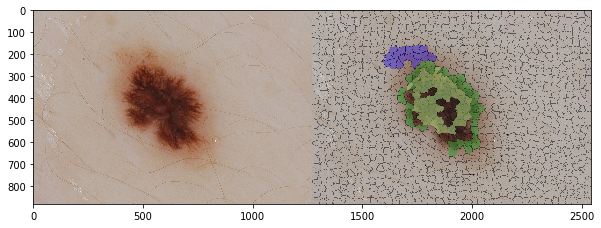

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(i22)
plt.show()

In [16]:
image = api.image('ISIC_0016094')
image.load_image_data()

In [134]:
from isicarchive import imfunc
imfunc.write_image(cf_2, 'C:\\Users\\weberj3\\Documents\\EASY_PILOT_DICE_confusion.png')

True

In [12]:
i2 = imfunc.image_mix(image.data, heatmap)

In [8]:
heatmap.shape

(882, 1272, 3)

In [18]:
import numpy
i22 = numpy.concatenate((image.data,i2), axis=1)

In [21]:
ost = numpy.load(study_folder + 'overlap_features.npz')

In [22]:
ost

In [23]:
list(ost.keys())

['feature_dice',
 'featcat_dice',
 'category_dice',
 'feature_smcc',
 'featcat_smcc',
 'category_smcc']

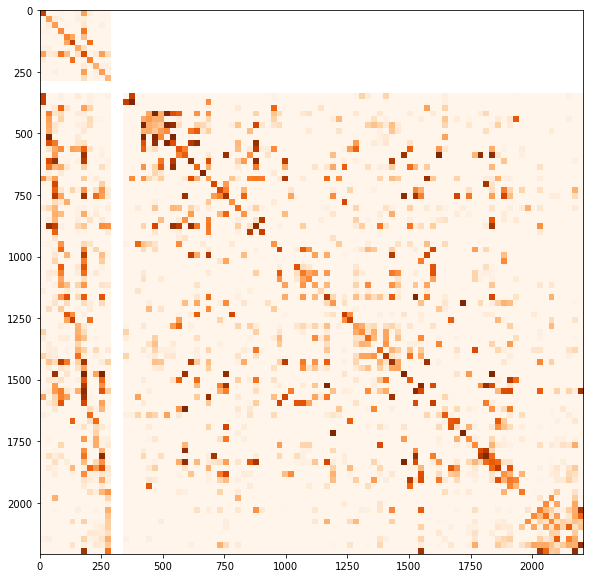

In [35]:
cc_d = ost.get('category_dice')
cf_d = ost.get('featcat_dice')
ff_d = ost.get('feature_dice')
cc_d[numpy.isnan(cc_d)] = 0
cf_d[numpy.isnan(cf_d)] = 0
ff_d[numpy.isnan(ff_d)] = 0
f1v = numpy.zeros((cc_d.shape[0], 2,))
f2v = numpy.zeros((ff_d.shape[0], 2,))
f1v.fill(numpy.nan)
f2v.fill(numpy.nan)
fc_d = numpy.zeros((cc_d.shape[0], ff_d.shape[0],))
fc_d.fill(numpy.nan)
cc = numpy.concatenate((cc_d[:,:,0], f1v, fc_d), axis=1)
ff = numpy.concatenate((cf_d[:,:,0], f2v, ff_d[:,:,0]), axis=1)
f1h = numpy.zeros((2, cc.shape[1],))
f1h.fill(numpy.nan)
cf = numpy.concatenate((cc,f1h,ff), axis=0)
cf = numpy.repeat(numpy.repeat(cf, 24, axis=0), 24, axis=1)
plt.figure(figsize=(10,10))
plt.imshow(cf, cmap=plt.get_cmap('Oranges'))
plt.show()

In [45]:
with open(study_folder + 'dice_smcc_categories.txt', 'r') as tfile:
    categories = tfile.readlines()
with open(study_folder + 'dice_smcc_features.txt', 'r') as tfile:
    features = tfile.readlines()
categories.extend(['\n', '\n'])
categories.extend(features)

In [47]:
c_f = ''.join(categories).strip()
c_f

'Circles & Semicircles\nDots\nGlobules / Clods\nLines\nMiscellaneous\nNail lesions\nNetwork\nPattern\nRegression structures\nShiny white structures\nStructureless\nVessels\n\n\nCircles & Semicircles : Brown\nCircles & Semicircles : Circle within a circle\nCircles & Semicircles : NOS\nDots : Black\nDots : Blue-gray\nDots : Brown\nDots : Irregular\nDots : NOS\nDots : Regular\nGlobules / Clods : Blue\nGlobules / Clods : Blue-gray ovoid nests\nGlobules / Clods : Cobblestone pattern\nGlobules / Clods : Comedo-like openings\nGlobules / Clods : Concentric\nGlobules / Clods : Irregular\nGlobules / Clods : Lacunae : Black\nGlobules / Clods : Lacunae : Red\nGlobules / Clods : Lacunae : Red-purple\nGlobules / Clods : Leaflike area\nGlobules / Clods : Milia-like cysts\nGlobules / Clods : Milky red\nGlobules / Clods : NOS\nGlobules / Clods : Regular\nGlobules / Clods : Rim of brown globules\nGlobules / Clods : White\nLines : Angulated lines / Polygons / Zig-zag pattern\nLines : Branched streaks\nLi

In [69]:
c_f_text = f.set_line(c_f.split('\n'),fsize=23)

In [55]:
from isicarchive.font import Font
f = Font('calibri')


In [80]:
c_f_y = [v for v in map(lambda x: x.shape[0], c_f_text)]

In [91]:
cf_ti = numpy.zeros((2208,500,3), dtype=numpy.uint8)
cf_ti.fill(255)

In [75]:
cf.shape

(2208, 2208)

In [87]:
len(c_f_text)
c_f_text[0].shape

(24, 166)

In [97]:
for r in range(len(c_f_text)):
    if c_f_text[r].shape[0] < 24:
        continue
    fy = r * 24
    fx = 500-c_f_text[r].shape[1]
    cf_ti[fy:fy+24,fx:,0] = 255-c_f_text[r]
    cf_ti[fy:fy+24,fx:,1] = 255-c_f_text[r]
    cf_ti[fy:fy+24,fx:,2] = 255-c_f_text[r]

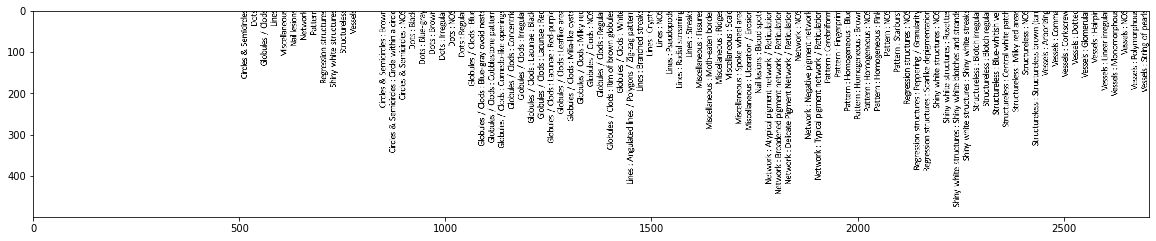

In [112]:
plt.figure(figsize=(20,10))
plt.imshow(cf_tx, cmap=plt.get_cmap('Oranges'))
plt.show()

In [106]:
cf_tt = numpy.transpose(cf_ti[:,::-1,:], (1,0,2,))

In [111]:
cf_tx = numpy.concatenate((numpy.uint8(255) * numpy.ones((500,500,3,), dtype=numpy.uint8), cf_tt), axis=1)

In [132]:
cf_1 = numpy.concatenate((cf_ti, cf_cmu[:,:,0:3]), axis=1)
cf_2 = numpy.concatenate((cf_1, cf_tx), axis=0)

In [116]:
cf_ti.shape

(2208, 500, 3)

In [117]:
import matplotlib as mpl
import matplotlib.cm as cm
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
cf_m = cm.ScalarMappable(norm=norm, cmap="Oranges")


In [122]:
cf_cm = cf_m.to_rgba(cf)

C:\Users\weberj3\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [131]:
cf_cmu = (255 * cf_cm).astype(numpy.uint8)

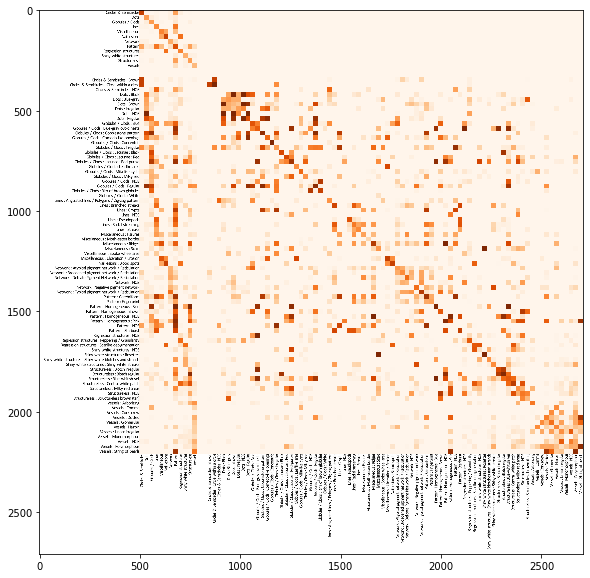

In [133]:
plt.figure(figsize=(10,10))
plt.imshow(cf_2)
plt.show()